In [4]:
import numpy as np
from matplotlib import pyplot as plt


from tiepy.speckle.io import load_tiff_as_npy
from tiepy.speckle.subpixel import process_single_image, process_subset_images, calculate_normalized_correlation
from tiepy.speckle.utils import get_subsets, reshape_to_2d

from PIL import Image
from tqdm import tqdm

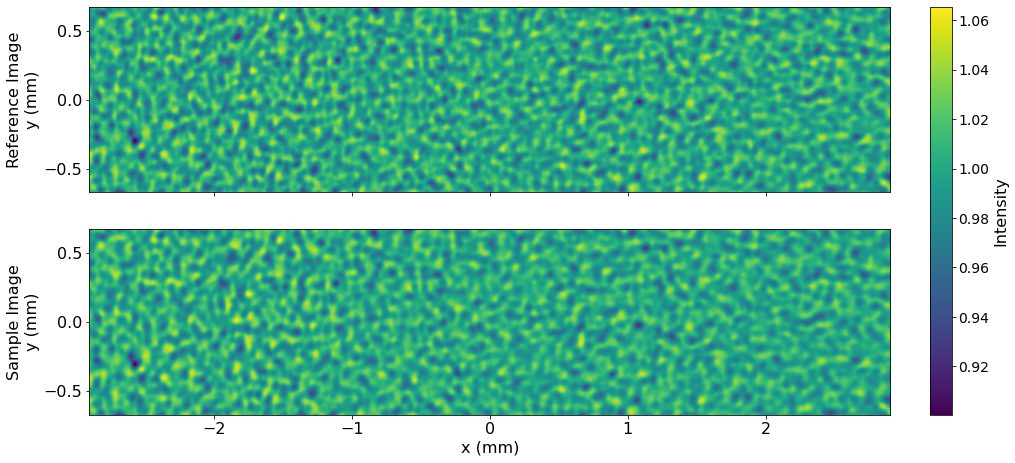

In [5]:

# Load the Data and scale to image mean
IR = load_tiff_as_npy("./data/speckle00.tif")
IS = load_tiff_as_npy("./data/speckle01.tif")

IR/= np.mean(IR)
IS/= np.mean(IS)
     
# Assuming IR and IS are the two images
z = 3.5  # speckle to detector distance
dx = dy = 7e-06  # pixel size

# Set array dimensions
ny, nx = IR.shape

x_axis = np.linspace(-dx * (nx // 2), dx * (nx // 2), nx) * 1e3  # in microns
y_axis = np.linspace(-dy * (ny // 2), dy * (ny // 2), nx) * 1e3  # in microns

# Plot Reference and Sample Speckle
fig, axes = plt.subplots(2, 1, figsize=(15, 7.5), sharex=True)
[ax1, ax2] = axes

# Plot IR (Reference Image)
im1 = ax1.imshow(IR, extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()])
ax1.set_ylabel("Reference Image\ny (mm)", fontsize=16)

# Plot IS (Sample Image)
im2 = ax2.imshow(IS, extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()])
ax2.set_ylabel("Sample Image\ny (mm)", fontsize=16)
ax2.set_xlabel("x (mm)", fontsize=16)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=16)

# Add a vertical colorbar to the right of the subplots
cax = fig.add_axes([0.92, 0.125, 0.02, 0.755])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Intensity', fontsize=16)

plt.show()

In [13]:
subset, centers = get_subsets(IS, window_size = 50, step_size = 20, padding = 0)
print("Number of Subset Images: {}".format(len(subset)))

Number of Subset Images: 312


In [14]:
result = process_single_image(IR,
                            IS,
                            window_size = 50,
                            step_size = 22,
                            padding = 0,
                            plot = False)

5it [00:04,  1.21it/s]


KeyboardInterrupt: 

In [18]:
from tiepy.speckle.subpixel import reshape_to_2d

In [8]:
cx = np.array([result['subset_centers'][a][0] for a in range(len(result['subset_centers']))])
cy = np.array([result['subset_centers'][a][1] for a in range(len(result['subset_centers']))])
ssx = np.array([result['subpixel_shifts'][a][1] for a in range(len(result['subpixel_shifts']))])


In [32]:
len(result['subset_centers'])

228

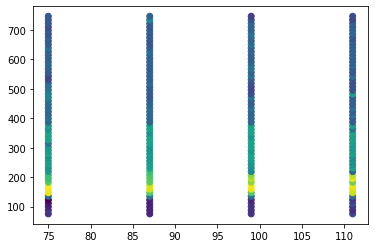

In [39]:
# for itr, pos in enumerate((result['subset_centers'])):
#     plt.scatter(*pos, s = result['subpixel_shifts'][itr][1] )
plt.scatter(cx, cy, c = ssx)

In [51]:
xx, yy = np.meshgrid(cx,cy)

In [44]:
output_file = './output.h5'
save_dict_to_hdf5(output_file, data_dict, 'my_data')

In [51]:
import h5py as h5

results = {}
group = 'my_data'

with h5.File(output_file) as F:
    
    for key in F[group].keys():
        results[key] = F[group][key][()]
        
print(results)

{'shifts': array([[0, 4],
       [0, 3],
       [0, 2],
       [0, 2],
       [0, 2]]), 'subpixel_shifts': array([[-0.21893171,  3.91206204],
       [ 0.        ,  3.        ],
       [ 1.08602309,  2.01209122],
       [-0.03696067,  1.75118365],
       [-0.14684278,  1.64573496]]), 'subset_centers': array([[ 50, 175],
       [ 50, 200],
       [ 50, 225],
       [ 50, 250],
       [ 50, 275]])}


<Closed HDF5 dataset>